### Overview

The purpose of this project is to implement an algorithm that can categorize news headlines based on the content of the headline. The dataset for this project consists of a databased of news headlines. each of which belongs to one of the categories; "business", "entertainment", 'medical', or 'science and technology. Our job is to train an LSTM that can accuractely categorize a previously unseen news headline, into one of these categories.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

### Loading and Inspecting the data

In [2]:
newsdf = pd.read_csv('newsCorpora.csv', sep="\t", header=None, index_col=0)

In [3]:
newsdf.shape

(422419, 7)

In [4]:
newsdf.head()

,1,2,3,4,5,6,7
0,,,,,,,
1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [5]:
newsdf.isnull().sum(axis=0)
#There are 2 null values in the dataset.
#Column 3 however will not be a column of interest for us.

1    0
2    0
3    2
4    0
5    0
6    0
7    0
dtype: int64

In [6]:
newsdf = newsdf.drop([3, 5, 6, 7], axis=1).rename(columns={1:"Headline", 2: "URL", 4: "Category" })

In [7]:
newsdf.head()

,Headline,URL,Category
0,,,
1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,b
2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,b
3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,b
4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,b
5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,b


In [8]:
newsdf = newsdf.drop_duplicates()
newsdf.shape
#There was only one duplicated entry in the df

(422228, 3)

### Examples of headlines from the various categories

In [9]:
newsdf[newsdf.Category == 'b'].Headline.iloc[0]
#Below is an example of a headline that belongs to the business category.

'Fed official says weak data caused by weather, should not slow taper'

In [10]:
newsdf[newsdf.Category == 'e'].Headline.iloc[0]
#Below is an example of a headline that belongs to the entertainment category.

'George Zimmerman Has an Armed Life on the Move'

In [11]:
newsdf[newsdf.Category == 'm'].Headline.iloc[0]
#Below is an example of a headline that belongs to the medical category.

'Grown-ups: Put down the smartphones at mealtime'

In [12]:
newsdf[newsdf.Category == 't'].Headline.iloc[0]
#Below is an example of a headline that belongs to the technology category.

'Titanfall Review Roundup'

### Data Set Distribution

In [13]:
newsdf.Category.value_counts()
#This tells us our newsdf data is imbalanced

e    152387
b    115920
t    108306
m     45615
Name: Category, dtype: int64

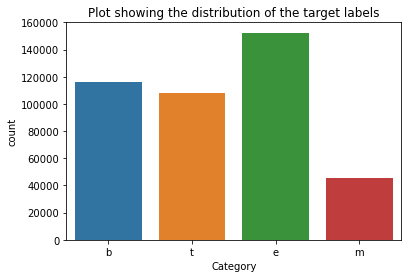

In [14]:
sns.countplot(data=newsdf, x='Category')
plt.title("Plot showing the distribution of the target labels")
plt.show()

`From the plot above, we can see that the classes are imbalamnced, with the medical category being the minority category.To solve the problem of imbalanced classes we will use undersampling techniques to reduce the number of occurences of the majority classes.`

### Manual Under Sampling

In [15]:
permutizer = np.random.permutation(newsdf.index)
newsdf = newsdf.reindex(permutizer)
#First, the current indices are randomly permuted.
#This randomly permuted list of indices is then used to reindex the DF
#This way, when we select the first k samples we are selecting a truly random sample.

In [16]:
permutizer[:5]

array([239978, 309581,  16498, 304958, 159065], dtype=int64)

In [17]:
newsdf.head()

,Headline,URL,Category
0,,,
239978,Update: Paul McCartney has been hospitalized,http://consequenceofsound.net/2014/05/report-p...,e
309581,Oracle to purchase Micros Systems for $5.3 bil...,http://www.thewestsidestory.net/2014/06/23/133...,t
16498,"GM Ramps Up Recalls, Adds 1.3 Million Units",http://www.autoremarketing.com/retail/gm-ramps...,b
304958,USDA grants license for PEDv vaccine,http://www.farmanddairy.com/news/usda-grants-l...,m
159065,Nasdaq ends higher on Apple; Ukraine curbs bro...,http://www.cnbc.com/id/101610518,b


In [18]:
b = newsdf[newsdf.Category == "b"].iloc[:45000]
e= newsdf[newsdf.Category == "e"].iloc[:45000]
m = newsdf[newsdf.Category == "m"].iloc[:45000]
t = newsdf[newsdf.Category == "t"].iloc[:45000]


In [19]:
b.head()

,Headline,URL,Category
0,,,
16498,"GM Ramps Up Recalls, Adds 1.3 Million Units",http://www.autoremarketing.com/retail/gm-ramps...,b
159065,Nasdaq ends higher on Apple; Ukraine curbs bro...,http://www.cnbc.com/id/101610518,b
305451,"Matter of concern: For now, Amazon Fire phone ...",http://tech.firstpost.com/news-analysis/matter...,b
29819,29 of 30 big banks pass Fed's stress test,http://www.washingtonpost.com/business/economy...,b
248011,PBS's Ifill Fails to Ask Geithner About Admiss...,http://newsbusters.org/blogs/paul-bremmer/2014...,b


In [20]:
b.shape, e.shape, t.shape, m.shape

((45000, 3), (45000, 3), (45000, 3), (45000, 3))

In [21]:
balanced = pd.concat([e, b, m, t], axis=0, ignore_index=True)

In [22]:
balanced.head()

,Headline,URL,Category
0,Update: Paul McCartney has been hospitalized,http://consequenceofsound.net/2014/05/report-p...,e
1,Tonight's TV picks: Jack's back in '24: Live A...,http://www.mercurynews.com/spotlight/ci_256981...,e
2,"'Full House' Revival: Original Cast, Producers...",http://www.hngn.com/articles/40402/20140826/fu...,e
3,Report: Authorities Investigating Willow Smith...,http://www.wlac.com/onair/dan-eidem-49263/repo...,e
4,"NPH, At Last! See How I Met Your Mother Stars ...",http://www.broadway.com/buzz/175207/nph-at-las...,e


In [23]:
balanced.tail()

,Headline,URL,Category
179995,"Astronomers spot distant planet in ""habitable ...",http://www.laprensasa.com/309_america-in-engli...,t
179996,Year-on-year revenue rise for Apple,http://news.uk.msn.com/year-on-year-revenue-ri...,t
179997,"After Detour, Soyuz Successfully Docks With ISS",http://wwno.org/post/after-detour-soyuz-succes...,t
179998,Aussie scientists create new element,http://www.tntmagazine.com/news/australia-news...,t
179999,Could the DirecTV Deal Threaten AT&T's Dividend?,http://www.fool.com/investing/general/2014/05/...,t


In [24]:
balanced_df = balanced.sample(len(balanced))
#This second reindexing is to ensure the classes ocur at random throughout the dataset

In [25]:
balanced_df.head()

,Headline,URL,Category
98508,Tick season underway in Kittitas County,http://www.dailyrecordnews.com/inbrief/tick-se...,m
77195,WSJ: AT&T/DirecTV deal could be announced in t...,http://seekingalpha.com/news/1745053-wsj-at-an...,b
132516,Playtex Breast Pump Power Adapters Recalled Du...,http://consumer.healthday.com/health-technolog...,m
51715,GM Recalls 3.2 Million More Cars For Faulty Ig...,http://kplu.org/post/gm-recalls-32-million-mor...,b
100940,Hysterectomy device pulled off market,http://www.battlecreekenquirer.com/usatoday/ar...,m


In [26]:
balanced_df.head(1000).Category.value_counts()
#This demonstrates the effectiveness of our balancing operation

m    263
t    248
b    246
e    243
Name: Category, dtype: int64

### Label Encoding of the target labels

In [27]:
le = LabelEncoder()
enclabels = le.fit_transform(balanced_df.Category)

In [28]:
enclabels

array([2, 0, 2, ..., 1, 2, 1])

In [29]:
le.classes_

array(['b', 'e', 'm', 't'], dtype=object)

In [30]:
balanced_df.loc[:,"Category"] = enclabels

In [31]:
balanced_df.head()

,Headline,URL,Category
98508,Tick season underway in Kittitas County,http://www.dailyrecordnews.com/inbrief/tick-se...,2
77195,WSJ: AT&T/DirecTV deal could be announced in t...,http://seekingalpha.com/news/1745053-wsj-at-an...,0
132516,Playtex Breast Pump Power Adapters Recalled Du...,http://consumer.healthday.com/health-technolog...,2
51715,GM Recalls 3.2 Million More Cars For Faulty Ig...,http://kplu.org/post/gm-recalls-32-million-mor...,0
100940,Hysterectomy device pulled off market,http://www.battlecreekenquirer.com/usatoday/ar...,2


In [32]:
labels = tf.keras.utils.to_categorical(balanced_df.Category)

In [33]:
labels

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [34]:
balanced_df.Headline.head()

98508               Tick season underway in Kittitas County
77195     WSJ: AT&T/DirecTV deal could be announced in t...
132516    Playtex Breast Pump Power Adapters Recalled Du...
51715     GM Recalls 3.2 Million More Cars For Faulty Ig...
100940                Hysterectomy device pulled off market
Name: Headline, dtype: object

In [35]:
X, y = balanced_df.Headline, labels

In [36]:
print(X.shape, y.shape)

(180000,) (180000, 4)


### Text Preprocessing and Feature Extraction

In [37]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords = stopwords.words("english")
from string import punctuation

In [38]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
to_remove = list(set(punctuation).union(set(stopwords)))
to_remove[:20]

['below',
 'how',
 "doesn't",
 'we',
 "hadn't",
 '{',
 'all',
 'into',
 'out',
 'them',
 'myself',
 'so',
 'had',
 'nor',
 'your',
 '(',
 'their',
 'm',
 'few',
 'him']

In [40]:
lemmatizer = WordNetLemmatizer()

In [41]:
def text_preprocessor(doc):
    doc = doc.lower()
    doc = nltk.word_tokenize(doc)
    doc = [lemmatizer.lemmatize(word) for word in doc if word not in to_remove and word.isalpha()]
    doc = " ".join(doc)

    return doc

In [42]:
X.loc[10]

"New Photos: Angelina Jolie Goes Strapless At The 'Maleficent' Photo Call, Adam  ..."

In [43]:
text_preprocessor(X.loc[10])
#An example of text after cleaning and lemmatization

'new photo angelina jolie go strapless photo call adam'

In [44]:
train_data = X.apply(text_preprocessor)

In [45]:
train_data

98508                  tick season underway kittitas county
77195                     wsj deal could announced two week
132516    playtex breast pump power adapter recalled due...
51715          gm recall million car faulty ignition switch
100940                    hysterectomy device pulled market
                                ...                        
78471                           argentina default time year
167312    everyone feel heat warns un climate change report
17004     lana del rey cool video lana dance another old...
115497    change cow eat could mean higher beer price fu...
5429      box office guru wrapup divergent crush competi...
Name: Headline, Length: 180000, dtype: object

### Text Feature Extraction

In [46]:
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)

In [47]:
tokenizer

In [48]:
 tokenizer.fit_on_texts(train_data)

In [49]:
len(tokenizer.index_word)
#There are 31,415 unique words in the vocabulary

31533

In [50]:
tokenizer.index_word
#The dictionary below gies a snapshot of the most popular words in the vocabulary
#We will only consider the top 10000 words

{1: 'new',
 2: 'u',
 3: 'say',
 4: 'google',
 5: 'may',
 6: 'apple',
 7: 'study',
 8: 'report',
 9: 'ebola',
 10: 'samsung',
 11: 'video',
 12: 'first',
 13: 'health',
 14: 'get',
 15: 'show',
 16: 'price',
 17: 'stock',
 18: 'microsoft',
 19: 'cancer',
 20: 'day',
 21: 'facebook',
 22: 'one',
 23: 'sale',
 24: 'galaxy',
 25: 'could',
 26: 'million',
 27: 'year',
 28: 'case',
 29: 'rate',
 30: 'risk',
 31: 'update',
 32: 'west',
 33: 'watch',
 34: 'star',
 35: 'china',
 36: 'deal',
 37: 'recall',
 38: 'rise',
 39: 'death',
 40: 'virus',
 41: 'world',
 42: 'review',
 43: 'news',
 44: 'launch',
 45: 'time',
 46: 'make',
 47: 'top',
 48: 'market',
 49: 'mers',
 50: 'amazon',
 51: 'season',
 52: 'data',
 53: 'take',
 54: 'drug',
 55: 'billion',
 56: 'buy',
 57: 'android',
 58: 'kardashian',
 59: 'woman',
 60: 'help',
 61: 'kim',
 62: 'back',
 63: 'find',
 64: 'share',
 65: 'twitter',
 66: 'hit',
 67: 'game',
 68: 'test',
 69: 'car',
 70: 'plan',
 71: 'gm',
 72: 'outbreak',
 73: 'life',
 74

In [51]:
balanced_df.Headline.head(3)

98508               Tick season underway in Kittitas County
77195     WSJ: AT&T/DirecTV deal could be announced in t...
132516    Playtex Breast Pump Power Adapters Recalled Du...
Name: Headline, dtype: object

In [52]:
sequences = tokenizer.texts_to_sequences(train_data)
#This line of code will convert each entry(document) in the Headline column of balancedf to a sequence of integers

In [53]:
sequences[:3]
#This is what we transform our Series/list of documents into
#Each word in the document (with the exception of the filtered words) has been converted to an integer)


[[1432, 51, 3100, 183],
 [3133, 36, 25, 771, 126, 82],
 [321, 2765, 467, 314, 243, 1250, 30]]

In [54]:
X = pad_sequences(sequences, maxlen=60)

In [55]:
X

array([[   0,    0,    0, ...,   51, 3100,  183],
       [   0,    0,    0, ...,  771,  126,   82],
       [   0,    0,    0, ...,  243, 1250,   30],
       ...,
       [   0,    0,    0, ...,  203, 1146,  159],
       [   0,    0,    0, ..., 2615,   16,  122],
       [   0,    0,    0, ..., 2905,  930, 1646]])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, labels)

In [57]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(135000, 60) (135000, 4)
(45000, 60) (45000, 4)


### Model building and training

In [58]:
vocab_size = 10000
embed_size = 128
sequence_len = 120

In [59]:
model = Sequential()

In [60]:
model.add(Embedding(input_dim=vocab_size, output_dim=embed_size))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(units=100, activation='tanh', input_shape=(sequence_len, embed_size), dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation="softmax"))

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               91600     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 1,372,004
Trainable params: 1,372,004
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [63]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.2, verbose=True, callbacks=[EarlyStopping(monitor="val_loss", patience=2)])

Epoch 1/5
1688/1688 [==============================] - 167s 98ms/step - loss: 0.4658 - accuracy: 0.8252 - val_loss: 0.2435 - val_accuracy: 0.9163
Epoch 2/5
1688/1688 [==============================] - 170s 101ms/step - loss: 0.2518 - accuracy: 0.9123 - val_loss: 0.2218 - val_accuracy: 0.9234
Epoch 3/5
1688/1688 [==============================] - 168s 100ms/step - loss: 0.2176 - accuracy: 0.9239 - val_loss: 0.2156 - val_accuracy: 0.9250
Epoch 4/5
1688/1688 [==============================] - 171s 101ms/step - loss: 0.1985 - accuracy: 0.9298 - val_loss: 0.2160 - val_accuracy: 0.9269
Epoch 5/5
1688/1688 [==============================] - 164s 97ms/step - loss: 0.1842 - accuracy: 0.9352 - val_loss: 0.2178 - val_accuracy: 0.9271


### Model Evaluation and Analysis

In [64]:
evaluation = model.evaluate(X_test, y_test)
#The model generalizes very well to the test set.

1407/1407 [==============================] - 13s 9ms/step - loss: 0.2189 - accuracy: 0.9254


In [65]:
train_accuracy_hist = history.history["accuracy"]
val_accuracy_his = history.history['val_accuracy']

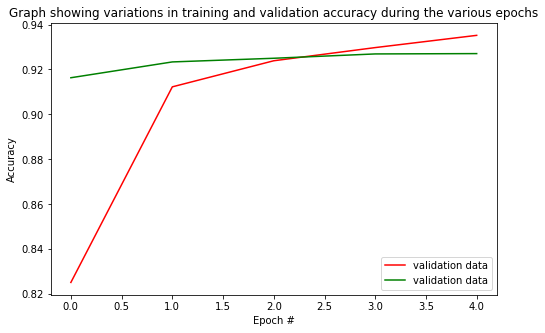

In [66]:
plt.figure(figsize=(8, 5))
plt.plot(train_accuracy_hist, "r", label="validation data")
plt.plot(val_accuracy_his, 'g', label="validation data")
plt.title("Graph showing variations in training and validation accuracy during the various epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epoch #")
plt.legend(loc=4)
plt.show()

`The graph above shows that the training accuray and validation accuracy are quite similar. hence we can expect the model to generalize well to unseen data. The two accuracies do seem to diverge a bit after epoch 2, however, hence this algorithm may be a candidate for training using early stopping.`

In [67]:
train_loss_hist = history.history["loss"]
val_loss_his = history.history['val_loss']

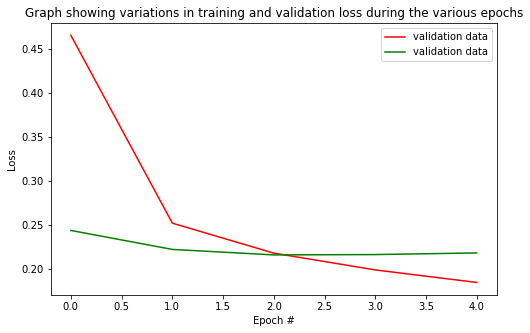

In [68]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_hist, "r", label="validation data")
plt.plot(val_loss_his, 'g', label="validation data")
plt.title("Graph showing variations in training and validation loss during the various epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch #")
plt.legend(loc=1)
plt.show()

`The graph above conveys the same sentiments as the previous graph`

### Model Application

In [69]:
def process_text(doc):
    
    """ This function inputs a piece of text/ document and outputs the category the text belongs to"""
    doc = text_preprocessor(doc)
    sequence_to_predict = tokenizer.texts_to_sequences([doc])
    padded_sequence = pad_sequences(sequence_to_predict, maxlen=60)
    results = model.predict(padded_sequence)
    
    cat = np.argmax(results)
    classes = ["business", "entertainment", 'medical', 'science and technology']

    return classes[cat]


In [70]:
text = "regular fast food eating leads to fertility issues in women"
#An example of a headline that could be given to the process_text function

In [71]:
process_text(text)
#The function outputs the category the example belongs to.

'medical'